In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import math

In [50]:
# helper functions
def printTable(header, data):
    """
    Prints table with columns of header and data.

    Parameters
    ----------
    header : []
        list of header labels
        ex. header = ["one","two","three"]
    data : [[],[],...,[]]
        list of lists, each inner list is a data line
        data line must index with header appropriately
        ex. data = [[1, 2, 3],[1, 2, 3]]
    """

    # print headers
    col_widths=[]
    for i,label in enumerate(header):
        col_widths.append(len(label))
        if i == 0 :
            print("| ",end="")
        print(str(label).center(len(label)), end=" | ")
    print()

    # print separating line
    for i,width in enumerate(col_widths):
        if i == 0 :
            print("| ",end="")
        print("".center(width,"-"), end=" | ")
    print()

    # print data
    for i,line in enumerate(data):
        for i,value in enumerate(line):
            if i == 0 :
                print("| ",end="")
            print(str(value).center(col_widths[i]), end=" | ")
        print()
        
def read_hand_data(filename):
    # parse json file to features
    data_file_name = '../data/'+filename
    nPoints = 21
    with open(data_file_name) as json_file:
        data = json.load(json_file)

        # matrix to store distance to keypoint 0, each image stored in row
        # column array to store labels

        distance_feature = np.ones((int(data["num_pics"]), nPoints-1))
        label_vector = np.ones((int(data["num_pics"]),1))

        # loop through json to constuct feature array
        for i in range(1, int(data["num_pics"])+1): # use num_pics+1 because range ends at integer before stop value
            label = data["pics"][str(i)]["label"] 
            points = np.array(data["pics"][str(i)]["keypoints"] )

            # label array
            label_vector[i-1] = label
            # feature matrix
            pointZero = points[0] # reference distance from point 0
            for j in range(1,nPoints): # calculate distances for points 1-20
                distance_feature[i-1][j-1] = math.sqrt(np.sum(np.square(points[j] - pointZero)))

    return distance_feature, label_vector

def plot_ovr_results(classes, b_classes, b_hat_svm, b_hat_ls, title):
    fig,ax = plt.subplots(len(classes),1)
    plt.rcParams['figure.figsize'] = [20, 10] # matplotlib window size = [width, height]
    
    for c in classes:
        ax[c].set_title("Class {} vs. Rest".format(c),fontsize=15)
        ax[c].scatter(range(len(b_classes[:,c])), b_classes[:,c], label="true", color="C0", s=15)
        ax[c].plot(range(len(b_classes[:,c])), b_classes[:,c], alpha=0.5, color="C0")
        ax[c].scatter(range(len(b_classes[:,c])), b_hat_svm[:,c], label="svm estimate", color="C1", s=15)
        ax[c].plot(range(len(b_classes[:,c])), b_hat_svm[:,c], alpha=0.5, color="C1")
        ax[c].scatter(range(len(b_classes[:,c])), b_hat_ls[:,c], label="ls estimate", color="C2", s=15)
        ax[c].plot(range(len(b_classes[:,c])), b_hat_ls[:,c], alpha=0.5, color="C2")
        ax[c].plot([0,len(b_classes[:,c])], [0,0], alpha=0.5, linestyle="--", color="k", label="decision boundary")
        ax[0].legend(bbox_to_anchor=(0.8, 2), loc='right', ncol=1,fontsize=12) # legend
    title = fig.suptitle(title, fontsize=20) # title
    fig.tight_layout() # prevent overlapping

## One vs. Rest

### Train

In [51]:
# get data
X, b = read_hand_data("data_train.json")

# model parameters
num_samples = len(b)
X_svm = np.hstack((X, np.ones((num_samples, 1))))
w_k = np.zeros((len(X[0])+1, 1))

r = 10 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize

# loop through each class
classes = [0,1,2,3,4,5]
w_svm = np.zeros((len(w_k),len(classes)))
w_ls = np.zeros((len(w_k),len(classes)))
descent_done = False

for c in classes:
    # form binary labels
    b_svm = np.where(b == c, 1, -1)
    last_loss = math.inf
    descent_done = False
    iterations = 0

    # train svm
    while not descent_done:
        loss = 0
        l_hinge = np.zeros(w_k.shape)
        # loop through training samples
        for s in range(num_samples):
            # indicator function
            if b_svm[s]*X_svm[s]@w_k <= 1:
                loss += (1-b_svm[s]*X_svm[s]@w_k)
                l_hinge = np.add(l_hinge, -b_svm[s]*X_svm[s].reshape(l_hinge.shape))
        w_tilda = np.copy(w_k)
        w_tilda[-1] = 0
        w_k = w_k - tau*(l_hinge+2*r*w_tilda)
        
        # compare loss to determine if reached minimum
        if(last_loss < loss):
            print("Class {} converged after {} iterations:".format(c,iterations))
            descent_done = True
        else:
            # svm weights
            w_tilda = np.copy(w_k)
            w_tilda[-1] = 0
            w_k = w_k - tau*(l_hinge+2*r*w_tilda)

        # update for next iteration
        last_loss = loss
        iterations +=1
        
    # save weights
    w_svm[:,c] = w_k.reshape(len(w_k)) # svm
    w_k_ls = np.linalg.inv(X_svm.T@X_svm)@X_svm.T@b_svm # least squares
    w_ls[:,c] = w_k_ls.reshape(len(w_k_ls))

Class 0 converged after 1165 iterations:
Class 1 converged after 1718 iterations:
Class 2 converged after 389 iterations:
Class 3 converged after 881 iterations:
Class 4 converged after 787 iterations:
Class 5 converged after 679 iterations:


### Test

| class | svm error | least squares error | 
| ----- | --------- | ------------------- | 
|   0   |   0.00 %  |        0.00 %       | 
|   1   |   0.00 %  |        0.00 %       | 
|   2   |   0.00 %  |        0.00 %       | 
|   3   |   0.00 %  |        0.00 %       | 
|   4   |   0.00 %  |        0.00 %       | 
|   5   |   0.00 %  |        0.00 %       | 


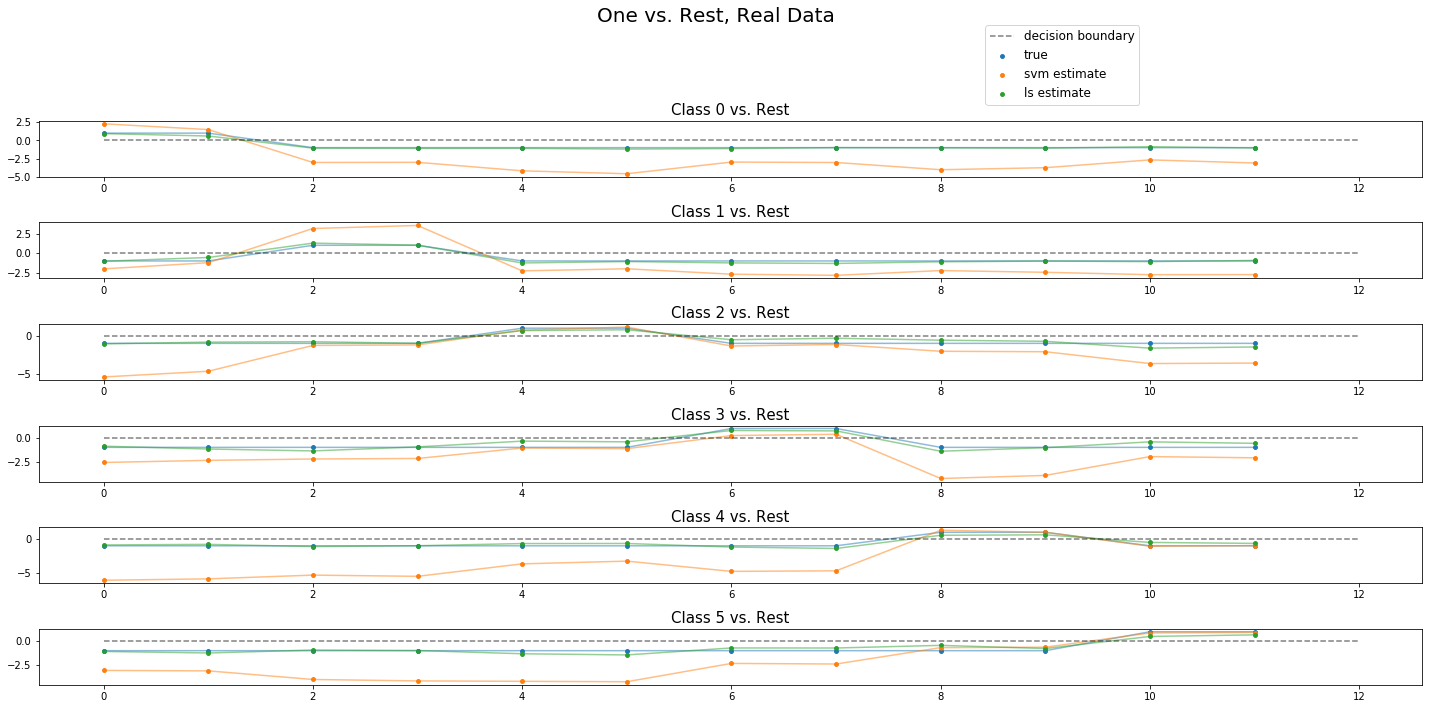

In [52]:
# test svm against new test data
X_test, b_test = read_hand_data("data_test.json")
num_samples = len(b_test)
X_test = np.hstack((X_test, np.ones((num_samples, 1))))

header = ["class", "svm error", "least squares error"]
data = []

classes = [0,1,2,3,4,5]
b_classes = np.zeros((len(b_test),len(classes)))
b_test = b_test.reshape((len(b_test),))
b_hat_svm = np.zeros(b_classes.shape)
b_hat_ls = np.zeros(b_classes.shape)

for c in classes:
    b_classes[:,c] = np.where(b_test == c, 1, -1)
    b_test_svm = X_test@w_svm[:,c]
    b_test_ls = X_test@w_ls[:,c]
    b_hat_svm[:,c] = b_test_svm.reshape(len(b_test))
    b_hat_ls[:,c] = b_test_ls.reshape(len(b_test))

    # find percent incorrect
    num_incorrect_ls = np.sum(np.sign(b_hat_ls[:,c]) != b_classes[:,c])
    percent_incorrect_ls = num_incorrect_ls/len(b_test)*100
    num_incorrect_svm = np.sum(np.sign(b_hat_svm[:,c]) != b_classes[:,c])
    percent_incorrect_svm = num_incorrect_svm/len(b_test)*100
    data.append([c,"{:0.2f} %".format(percent_incorrect_svm), "{:0.2f} %".format(percent_incorrect_ls)])

# print table
printTable(header,data)

# plot
plt.rcParams['figure.figsize'] = [20, 10] # matplotlib window size = [width, height]
title = "One vs. Rest, Real Data"
plot_ovr_results(classes, b_classes, b_hat_svm, b_hat_ls, title)
plt.show()